# Práctica

Se pide desarrollar una red neuronal para la clasificación de un conjunto de imágenes. Este conjunto puede ser creado por el propio alumno haciendo fotos de diferentes objetos en diferentes localizaciones y condiciones. Por ejemplo, libros, cubiertos de cocina, monedas, prendas de ropa… rollos de papel higiénico o lo que se tercie. El número recomendable de clases distintas será entre 4 y 7. Cada clase deberá tener un mínimo de 20 imágenes (cuantas más, mejor) para el conjunto de entrenamiento y 5 para el conjunto de validación. Una vez creado el *dataset* haremos lo siguiente:

-	Entrenar la red y visualizar gráficamente el progreso del *accuracy* tanto del conjunto de entrenamiento como del conjunto de validación. Para ello, se puede hacer uso del objeto <code>history</code> que devuelve el método <code>fit_generator</code> del modelo.


-	Hacer *data augmentation* sobre el conjunto de entrenamiento.


-	Probar con distintas configuraciones de hiperparámetros para escoger la que mejor resultados ofrezca.


-	*Categorical cross entropy* es una función de pérdida similar a la ya estudiada suma de diferencias al cuadrado. Explica cómo y por qué funciona esta función de pérdida.


In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf

In [3]:
# Verifica si TensorFlow tiene acceso a la GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print("Keras/TensorFlow tiene acceso a la GPU.")
else:
    print("Keras/TensorFlow está utilizando la CPU.")


Keras/TensorFlow tiene acceso a la GPU.


In [4]:
# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

# A partir de aquí, puedes continuar con la construcción y entrenamiento de tu modelo de Keras

In [10]:
def generatePlot(history):
    # Extracción de datos
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Datos propios

Este ejemplo es con este conjunto de datos: https://www.kaggle.com/datasets/anshtanwar/jellyfish-types

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import os

image_size = 150
data_dir = os.path.join('./datasets', 'jellyfish')
batch_size = 16
rescale_factor = 1./255

# Crear un generador para aumentar datos
train_datagen = ImageDataGenerator(
    rescale=rescale_factor,         # Normalizar los valores de los píxeles [entre 0 y 1]
    shear_range=0.2,                # Rango para las transformaciones aleatorias
    zoom_range=0.2,                 # Rango para el zoom aleatorio
    horizontal_flip=True,           # Activar el giro horizontal aleatorio
    validation_split=0.2)           # Establecer el porcentaje de imágenes para el conjunto de validación

# Cargar imágenes de entrenamiento
train_generator = train_datagen.flow_from_directory(
    data_dir,                                # Directorio con datos
    target_size=(image_size, image_size),    # Cambiar el tamaño de las imágenes a 50x50
    batch_size=batch_size,
    class_mode='categorical',                  # 'binary' para clasificación binaria, 'categorical' para multiclase
    subset='training') # Seleccionar solo el conjunto de entrenamiento

# Cargar imágenes de validación
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # Seleccionar solo el conjunto de validación

Found 1177 images belonging to 3 classes.
Found 293 images belonging to 3 classes.


Te habrás dado cuenta que ImageDataGenerator no divide en conjunto de test, es que no puede. Para añadir un conjunto de test al trabajar con `ImageDataGenerator` en Keras, necesitas un enfoque ligeramente diferente, ya que `ImageDataGenerator` por sí solo no proporciona una forma directa de dividir los datos en tres conjuntos (entrenamiento, validación y prueba). Aquí hay dos métodos comunes para hacerlo:

### Método 1: División Manual de los Datos
1. **Dividir Manualmente los Datos en Directorios**: Antes de usar `ImageDataGenerator`, divide tus datos manualmente en tres directorios: uno para entrenamiento, uno para validación y otro para pruebas. Por ejemplo:
    ```
    data/
        train/
            class1/
            class2/
        validation/
            class1/
            class2/
        test/
            class1/
            class2/
    ```
2. **Crear Generadores Separados**: Usa `ImageDataGenerator` para crear generadores separados para cada conjunto de datos.

    ```python
    train_datagen = ImageDataGenerator(rescale=1./255, ...)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        'data/train/', ...)
    validation_generator = validation_datagen.flow_from_directory(
        'data/validation/', ...)
    test_generator = test_datagen.flow_from_directory(
        'data/test/', ...)
    ```

### Método 2: Uso del Conjunto de Validación como Test
1. **Usar `validation_split` para Dividir Entrenamiento y Validación**: Primero, divide tus datos en entrenamiento y validación usando `validation_split` en `ImageDataGenerator`.

2. **Separar un Conjunto de Pruebas Después**: Después del entrenamiento, puedes apartar manualmente una parte de tu conjunto de validación (o entrenamiento) para usarlo como conjunto de prueba. Esto puede hacerse seleccionando un conjunto de imágenes y evaluando el modelo en ellas.

    ```python
    # Ya tienes train_generator y validation_generator

    # Después del entrenamiento, usa parte de validation_generator como test set
    # Por ejemplo, puedes hacer predicciones en un subconjunto de validation_generator
    # y evaluar el rendimiento del modelo
    ```

### Consideraciones Adicionales
- **Equilibrio de Clases**: Asegúrate de que cada conjunto (entrenamiento, validación, prueba) tenga una distribución similar de clases.
- **No Aumentación en Test**: Generalmente, no se aplican técnicas de aumentación de datos en el conjunto de prueba, solo el reescalado.
- **Consistencia en el Preprocesamiento**: Asegúrate de que el preprocesamiento (como el reescalado) sea consistente en todos los generadores.
- **Tamaño del Conjunto de Pruebas**: Decide cuántos datos deseas reservar para las pruebas. Un tamaño común para el conjunto de pruebas es entre el 10% y el 20% del conjunto de datos total.

Al elegir entre estos métodos, considera el tamaño de tu conjunto de datos y tus requisitos específicos de validación y prueba. La división manual en directorios ofrece la mayor flexibilidad y control.

Etiqueta: [0. 1. 0.]


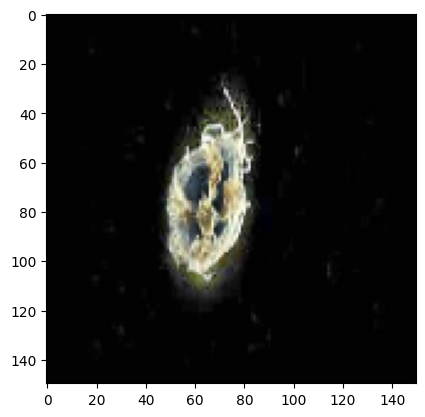

Etiqueta: [0. 1. 0.]


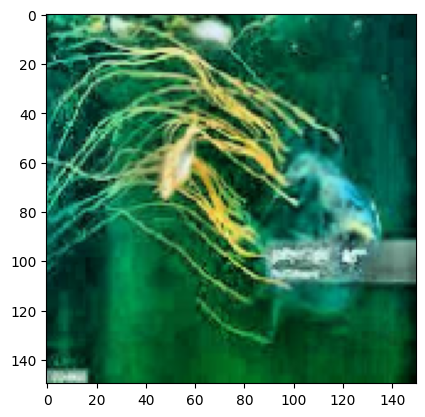

In [27]:
# ver imagenes
%matplotlib inline

x_batch, y_batch = next(train_generator)
for i in range (0, 2):
    image = x_batch[i]  # Obtener la imagen correspondiente del lote 
    label = y_batch[i]  # Obtener la etiqueta correspondiente a la imagen
    plt.imshow(image)   # Mostrar la imagen
    print(f"Etiqueta: {label}")  # Mostrar la etiqueta
    plt.show()

### Construir el modelo

In [32]:
model = Sequential()
# Capas convolucionales
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_size, image_size, 3))) # 3 canales de color
model.add(Dropout(0.25))  # Dropout después de la capa de conv2D
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Aplanar la salida de la capa convolucional
# Capas fully connected (clasificador)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout antes de la capa de salida
model.add(Dense(3, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 dropout_2 (Dropout)         (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 175232)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               22429824  
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

### Configurar Early Stopping

Early Stopping es una forma de detener el entrenamiento automáticamente cuando una métrica monitoreada deja de mejorar. Configúralo como un callback en Keras:

In [33]:
from keras.callbacks import EarlyStopping

# Configurar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)  # 'patience' es el número de épocas sin mejora después de las cuales el entrenamiento se detendrá

#### Añadir Early Stopping al Entrenamiento

Cuando entrenes tu modelo, pasa el callback de Early Stopping a través del argumento callbacks:

In [36]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 10

# Entrenar el modelo con Early Stopping
history_of_train = model.fit(
        train_generator,                                # Imágenes de entrenamiento
        epochs=epochs,                                  # Épocas
        validation_data = validation_generator,         # Imágenes de validación       
        callbacks = [early_stopping]                    # Se añade el Early Stopping
)

Epoch 1/10
74/74 [==============================] - 14s 169ms/step - loss: 0.8379 - accuracy: 0.6967 - val_loss: 0.8505 - val_accuracy: 0.6962
Epoch 2/10
74/74 [==============================] - 11s 149ms/step - loss: 0.8449 - accuracy: 0.6958 - val_loss: 0.8362 - val_accuracy: 0.6962
Epoch 3/10
74/74 [==============================] - 5s 71ms/step - loss: 0.8276 - accuracy: 0.6967 - val_loss: 0.8294 - val_accuracy: 0.6962
Epoch 4/10
74/74 [==============================] - 8s 108ms/step - loss: 0.8134 - accuracy: 0.6967 - val_loss: 0.8214 - val_accuracy: 0.6962
Epoch 5/10
74/74 [==============================] - 10s 133ms/step - loss: 0.8154 - accuracy: 0.6975 - val_loss: 0.8231 - val_accuracy: 0.6962
Epoch 6/10
74/74 [==============================] - 10s 140ms/step - loss: 0.8157 - accuracy: 0.6967 - val_loss: 0.8163 - val_accuracy: 0.6962
Epoch 7/10
74/74 [==============================] - 4s 50ms/step - loss: 0.8059 - accuracy: 0.6967 - val_loss: 0.8241 - val_accuracy: 0.6962
Epoc

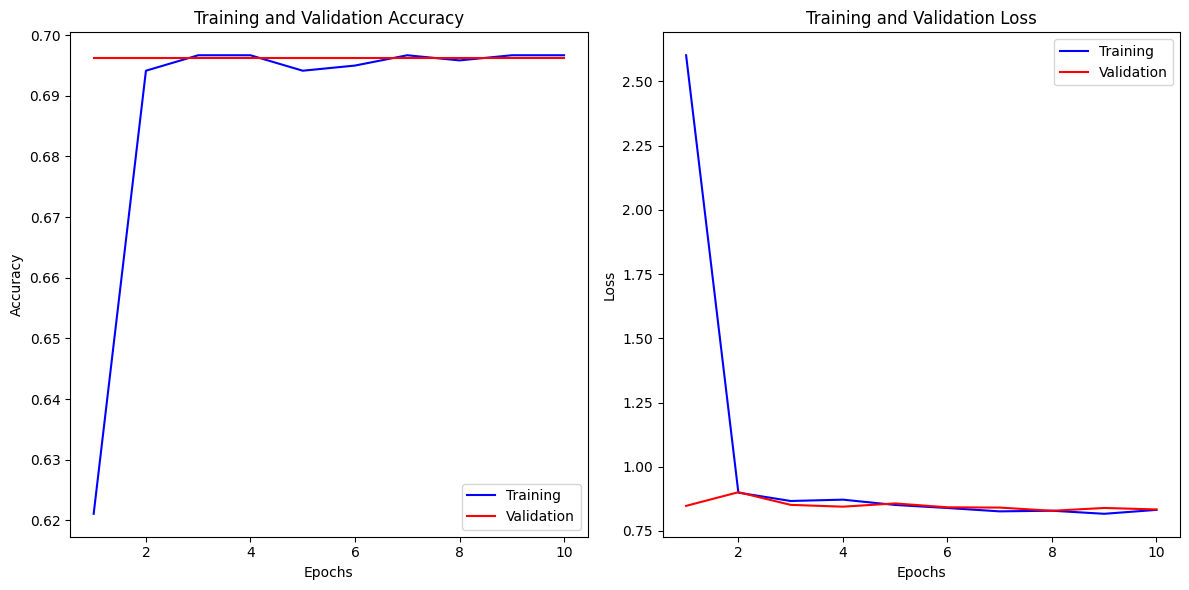

In [35]:
generatePlot(history_of_train)

#### test

In [11]:
# Evaluar el modelo en el conjunto de validación (usado aquí como prueba)
# Puedes limitar el número de pasos para usar solo una parte del conjunto
test_loss, test_accuracy = model.evaluate(validation_generator, steps=50)  # 'steps' es el número de lotes a evaluar

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


50/50 [==============================] - 2s 35ms/step - loss: 1.3789 - accuracy: 0.3840
Test Loss: 1.3789169788360596
Test Accuracy: 0.3840000033378601


Nuestra arquitectura actual representa un sólido punto de partida y ofrece una base excelente para futuras mejoras y experimentación. A partir de aquí, tenemos la oportunidad de afinar nuestra red, explorando ajustes en la arquitectura como añadir más capas o variar el número de filtros. Cada ajuste nos proporcionará información sobre cómo estas modificaciones impactan la precisión del modelo.

Además, experimentar con diferentes optimizadores y funciones de pérdida puede desvelar nuevas perspectivas y mejoras en el rendimiento. El campo del deep learning se caracteriza por su naturaleza experimental, donde la interpretación y la intuición juegan un rol clave. Te animo a que experimentes y explores diferentes enfoques, ya que esto es esencial para entender profundamente cómo cada cambio afecta al resultado final.

### Evaluacion de resultados

In [37]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in validation_generator], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

ModuleNotFoundError: No module named 'seaborn'